In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import folium


In [ ]:
url = "https://en.wikipedia.org/wiki/London_boroughs"

In [ ]:
london_data = requests.get(url).text

In [4]:
soup = BeautifulSoup(london_data,'lxml')

In [7]:
tables = soup.find('table',{'class':'wikitable sortable'})
london_df = pd.read_html(str(tables))
london_df=pd.DataFrame(london_df[0])
london_df.head()

,London borough,Designation,Former areas,Former areas.1,Former areas.2,Former areas.3,Former areas.4
0,Camden,Inner,Hampstead (11a),St Pancras (11b),Holborn (11c),NaN,NaN
1,Greenwich,Inner,Greenwich (22a),Woolwich (part) (22b),NaN,NaN,NaN
2,Hackney,Inner,Hackney (9a),Shoreditch (9b),Stoke Newington (9c),NaN,NaN
3,Hammersmith[notes 2],Inner,Hammersmith (4a),Fulham (4b),NaN,NaN,NaN
4,Islington,Inner,Islington (10a),Finsbury (10b),NaN,NaN,NaN


In [10]:
london_df.drop(london_df.columns.difference(['London borough']), 1, inplace=True)

In [12]:
len(london_df)

32

In [13]:
london_df.iloc[3, london_df.columns.get_loc('London borough')] = 'Hammersmith'

In [16]:
london_df.iloc[12, london_df.columns.get_loc('London borough')] = 'Barking'

In [18]:
london_df.head()

,London borough
0,Camden
1,Greenwich
2,Hackney
3,Hammersmith
4,Islington


In [19]:
import geocoder 

In [27]:
def get_latlng(borough):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, England'.format(borough))
        lat_lng_coords = g.latlng
    return lat_lng_coords
# Call the function to get the coordinates, store in a new list using list comprehension
coordinates = [get_latlng(borough) for borough in london_df["London borough"].tolist()]

In [28]:
len(coordinates)

32

In [29]:
london_coordinates = pd.DataFrame(coordinates,columns = ['Latitude','Longitude'])
london_df['Latitude'] = london_coordinates['Latitude']
london_df['Longitude'] = london_coordinates['Longitude']
print('The dataframe has {} rows and {} columns'.format(london_df.shape[0],london_df.shape[1]))
london_df.head()

The dataframe has 32 rows and 3 columns


,London borough,Latitude,Longitude
0,Camden,51.53236,-0.12796
1,Greenwich,51.48454,0.00275
2,Hackney,51.54505,-0.05532
3,Hammersmith,51.49617,-0.22935
4,Islington,51.53279,-0.10614


In [30]:
from geopy.geocoders import Nominatim
address = 'London, England'

geolocator = Nominatim(user_agent="chi_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of London are 51.5073219, -0.1276474.


In [34]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(london_df['Latitude'], london_df['Longitude'], london_df['London borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

In [35]:
CLIENT_ID = 'Q4TSPUQQ11S5HATKASHRF0X4XV5ANQKJDXHEUCX2GPLILWX0' # your Foursquare ID
CLIENT_SECRET = 'UHITQOVLYQHHJYJRUWIKXZQJPHMV0XM5YKYIWVJAOOBAJI3X' # your Foursquare Secret
VERSION = '20210103' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Q4TSPUQQ11S5HATKASHRF0X4XV5ANQKJDXHEUCX2GPLILWX0
CLIENT_SECRET:UHITQOVLYQHHJYJRUWIKXZQJPHMV0XM5YKYIWVJAOOBAJI3X


In [63]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name', 
                  'Name Latitude', 
                  'Name Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [64]:
london_df_venues = getNearbyVenues(names=london_df['London borough'],
                                   latitudes=london_df['Latitude'],
                                   longitudes=london_df['Longitude']
                                  )

Camden
Greenwich
Hackney
Hammersmith
Islington
Kensington and Chelsea
Lambeth
Lewisham
Southwark
Tower Hamlets
Wandsworth
Westminster
Barking
Barnet
Bexley
Brent
Bromley
Croydon
Ealing
Enfield
Haringey
Harrow
Havering
Hillingdon
Hounslow
Kingston upon Thames
Merton
Newham
Redbridge
Richmond upon Thames
Sutton
Waltham Forest


In [65]:
len(london_df_venues['Venue Category'].unique())

279

In [ ]:
# one hot encoding
london_onehot = pd.get_dummies(london_df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Borough'] = london_df_venues['Name'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

In [ ]:
london_grouped = london_onehot.groupby('Borough').mean().reset_index()
london_grouped.head()

In [89]:
num_top_venues = 5

for hood in london_grouped['Borough']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))

----Barking----
                  venue  freq
0                 Hotel  0.11
1           Supermarket  0.08
2  Fast Food Restaurant  0.08
3         Grocery Store  0.06
4        Clothing Store  0.06
----Barnet----
         venue  freq
0          Pub  0.08
1  Coffee Shop  0.08
2         Café  0.08
3  Yoga Studio  0.03
4     Wine Bar  0.03
----Bexley----
                      venue  freq
0                      Park  0.10
1  Mediterranean Restaurant  0.10
2             Movie Theater  0.05
3                 Gift Shop  0.05
4            Clothing Store  0.05
----Brent----
                  venue  freq
0                  Café  0.10
1     Indian Restaurant  0.07
2         Grocery Store  0.07
3  Fast Food Restaurant  0.05
4           Supermarket  0.05
----Bromley----
           venue  freq
0            Pub  0.20
1            Bar  0.09
2  Train Station  0.09
3    Supermarket  0.06
4       Bus Stop  0.06
----Camden----
                venue  freq
0                Café  0.07
1         Coffee Shop  0.

In [90]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [97]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = london_grouped['Borough']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking,Hotel,Fast Food Restaurant,Supermarket,Park,Coffee Shop,Indian Restaurant,Grocery Store,Sandwich Place,Clothing Store,Bakery
1,Barnet,Pub,Café,Coffee Shop,Yoga Studio,Restaurant,Wine Bar,Beer Bar,Italian Restaurant,Cocktail Bar,Pilates Studio
2,Bexley,Mediterranean Restaurant,Park,Bakery,Sports Club,Supermarket,Gas Station,Movie Theater,Gift Shop,Clothing Store,Gym / Fitness Center
3,Brent,Café,Grocery Store,Indian Restaurant,Japanese Restaurant,Metro Station,Supermarket,Turkish Restaurant,Coffee Shop,Fast Food Restaurant,Persian Restaurant
4,Bromley,Pub,Train Station,Bar,Bus Stop,Supermarket,Fast Food Restaurant,Lounge,Gym / Fitness Center,Mediterranean Restaurant,Metro Station
5,Camden,Café,Coffee Shop,Hotel,Breakfast Spot,Park,Burger Joint,Pizza Place,Mexican Restaurant,Escape Room,Plaza
6,Croydon,Grocery Store,Pub,Bus Stop,Fast Food Restaurant,Park,Turkish Restaurant,Coffee Shop,Café,Chinese Restaurant,Museum
7,Ealing,Coffee Shop,Pub,Park,Hotel,Italian Restaurant,Café,Burger Joint,Pizza Place,Thai Restaurant,Portuguese Restaurant
8,Enfield,Pub,Café,Restaurant,Coffee Shop,Grocery Store,Park,Middle Eastern Restaurant,Cocktail Bar,Bakery,Brewery
9,Greenwich,Pub,Grocery Store,Pizza Place,Garden,Café,Coffee Shop,Italian Restaurant,Park,Japanese Restaurant,Burger Joint


In [98]:
neighborhoods_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking,Hotel,Fast Food Restaurant,Supermarket,Park,Coffee Shop,Indian Restaurant,Grocery Store,Sandwich Place,Clothing Store,Bakery
1,Barnet,Pub,Café,Coffee Shop,Yoga Studio,Restaurant,Wine Bar,Beer Bar,Italian Restaurant,Cocktail Bar,Pilates Studio
2,Bexley,Mediterranean Restaurant,Park,Bakery,Sports Club,Supermarket,Gas Station,Movie Theater,Gift Shop,Clothing Store,Gym / Fitness Center
3,Brent,Café,Grocery Store,Indian Restaurant,Japanese Restaurant,Metro Station,Supermarket,Turkish Restaurant,Coffee Shop,Fast Food Restaurant,Persian Restaurant
4,Bromley,Pub,Train Station,Bar,Bus Stop,Supermarket,Fast Food Restaurant,Lounge,Gym / Fitness Center,Mediterranean Restaurant,Metro Station


In [99]:
from sklearn.cluster import KMeans
london_grouped_clustering = london_grouped.drop('Borough', 1)
# set number of clusters
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(london_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

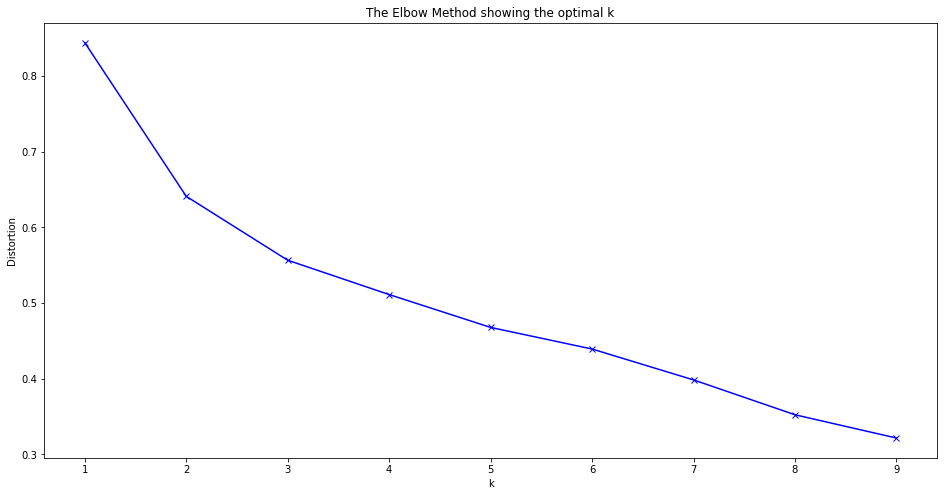

In [100]:

%matplotlib inline
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [101]:
clusterNum = 4
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(london_grouped_clustering)
labels = k_means.labels_
print(labels)

[3 0 1 3 1 0 3 0 1 1 1 1 1 0 0 1 3 0 1 0 1 1 0 3 1 1 0 1 1 2 1 0]


In [102]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', k_means.labels_)

london_merged = london_df

# merge manhattan_grouped with london_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Borough'), on='London borough')

london_merged.head() # check the last columns!

,London borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Camden,51.53236,-0.12796,0,Café,Coffee Shop,Hotel,Breakfast Spot,Park,Burger Joint,Pizza Place,Mexican Restaurant,Escape Room,Plaza
1,Greenwich,51.48454,0.00275,1,Pub,Grocery Store,Pizza Place,Garden,Café,Coffee Shop,Italian Restaurant,Park,Japanese Restaurant,Burger Joint
2,Hackney,51.54505,-0.05532,1,Pub,Café,Bakery,Coffee Shop,Brewery,Supermarket,Park,Pizza Place,Italian Restaurant,Vietnamese Restaurant
3,Hammersmith,51.49617,-0.22935,1,Pub,Café,Coffee Shop,Hotel,Indian Restaurant,Park,Italian Restaurant,Sandwich Place,Gym / Fitness Center,Japanese Restaurant
4,Islington,51.53279,-0.10614,0,Pub,Coffee Shop,Arts & Crafts Store,Mediterranean Restaurant,Hotel,French Restaurant,Café,Yoga Studio,Restaurant,Pizza Place


In [103]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [113]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['London borough'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [126]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,London borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Camden,Café,Coffee Shop,Hotel,Breakfast Spot,Park,Burger Joint,Pizza Place,Mexican Restaurant,Escape Room,Plaza
4,Islington,Pub,Coffee Shop,Arts & Crafts Store,Mediterranean Restaurant,Hotel,French Restaurant,Café,Yoga Studio,Restaurant,Pizza Place
8,Southwark,Coffee Shop,Pub,Seafood Restaurant,Restaurant,Italian Restaurant,Hotel,Bakery,Scenic Lookout,Asian Restaurant,Garden
11,Westminster,Hotel,Café,Coffee Shop,Plaza,Garden,Monument / Landmark,Outdoor Sculpture,Park,Indian Restaurant,Historic Site
13,Barnet,Pub,Café,Coffee Shop,Yoga Studio,Restaurant,Wine Bar,Beer Bar,Italian Restaurant,Cocktail Bar,Pilates Studio
18,Ealing,Coffee Shop,Pub,Park,Hotel,Italian Restaurant,Café,Burger Joint,Pizza Place,Thai Restaurant,Portuguese Restaurant
21,Harrow,Pub,Coffee Shop,Theater,Hotel,Falafel Restaurant,Gym / Fitness Center,Art Museum,Park,Scenic Lookout,Event Space
22,Havering,Coffee Shop,Pub,Café,Yoga Studio,Pizza Place,Grocery Store,Music Venue,Market,Middle Eastern Restaurant,Burger Joint
25,Kingston upon Thames,Pub,Coffee Shop,Clothing Store,Café,Gym / Fitness Center,Indian Restaurant,Sushi Restaurant,Italian Restaurant,Thai Restaurant,Japanese Restaurant
26,Merton,Grocery Store,Pub,Coffee Shop,Hotel,Italian Restaurant,Thai Restaurant,Bar,Park,Tram Station,Sushi Restaurant


In [123]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,London borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Greenwich,Pub,Grocery Store,Pizza Place,Garden,Café,Coffee Shop,Italian Restaurant,Park,Japanese Restaurant,Burger Joint
2,Hackney,Pub,Café,Bakery,Coffee Shop,Brewery,Supermarket,Park,Pizza Place,Italian Restaurant,Vietnamese Restaurant
3,Hammersmith,Pub,Café,Coffee Shop,Hotel,Indian Restaurant,Park,Italian Restaurant,Sandwich Place,Gym / Fitness Center,Japanese Restaurant
5,Kensington and Chelsea,Pub,Café,Pizza Place,Italian Restaurant,Bakery,Gym / Fitness Center,Cocktail Bar,Canal,Coffee Shop,Fish & Chips Shop
6,Lambeth,Pub,Café,Coffee Shop,Hotel,Park,Indian Restaurant,Italian Restaurant,Gay Bar,Gastropub,Dance Studio
7,Lewisham,Pub,Park,Café,Bakery,Restaurant,Coffee Shop,Fish & Chips Shop,Supermarket,Gym,Food Truck
9,Tower Hamlets,Pub,Coffee Shop,Park,Bakery,Café,Turkish Restaurant,Sandwich Place,Grocery Store,Gym,Gym / Fitness Center
10,Wandsworth,Pub,Hotel,Gym / Fitness Center,Coffee Shop,Café,Clothing Store,Asian Restaurant,Bus Stop,Breakfast Spot,Park
14,Bexley,Mediterranean Restaurant,Park,Bakery,Sports Club,Supermarket,Gas Station,Movie Theater,Gift Shop,Clothing Store,Gym / Fitness Center
16,Bromley,Pub,Train Station,Bar,Bus Stop,Supermarket,Fast Food Restaurant,Lounge,Gym / Fitness Center,Mediterranean Restaurant,Metro Station


In [124]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,London borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Waltham Forest,Pub,Fast Food Restaurant,Park,Financial or Legal Service,Yoga Studio,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop


In [125]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,London borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Barking,Hotel,Fast Food Restaurant,Supermarket,Park,Coffee Shop,Indian Restaurant,Grocery Store,Sandwich Place,Clothing Store,Bakery
15,Brent,Café,Grocery Store,Indian Restaurant,Japanese Restaurant,Metro Station,Supermarket,Turkish Restaurant,Coffee Shop,Fast Food Restaurant,Persian Restaurant
17,Croydon,Grocery Store,Pub,Bus Stop,Fast Food Restaurant,Park,Turkish Restaurant,Coffee Shop,Café,Chinese Restaurant,Museum
24,Hounslow,Indian Restaurant,Hotel,Coffee Shop,Clothing Store,Grocery Store,Fast Food Restaurant,Bakery,Pizza Place,Pub,Pharmacy
27,Newham,Grocery Store,Park,Supermarket,Gym / Fitness Center,Light Rail Station,Shopping Plaza,Farm,Coffee Shop,Furniture / Home Store,Soccer Field
